![logo](./img/LogoLine_horizon_C3S.png)

# Visualisation of Lake Surface Water Temperature (LSWT) data for a given lake

## Introduction

The Copernicus Climate Change Service (C3S) is a European program with the objective of providing information on the current and past state of the climate. All this information is freely available after registration through the Climate Data Store (CDS) (https://cds.climate.copernicus.eu).

One of the datasets available from CDS provides mid-morning daily values of Lake Surface Water Temperature (LSWT) derived from satellite radiometers. LSWT is one of the key parameters determining the ecological conditions within a lake, since it influences physical, chemical and biological processes. Lake water temperatures also determine air-water heat and moisture exchange and they are important for understanding the hydrological cycle. This dataset supports the investigation of large-scale lake-climate interaction on inter-annual time scales. The LSWT is provided on regular grid and accompained by the uncertainty and quality level information. Temporal gaps in time and space may be present as the dataset contains only observations from the radiometer sensors. A detailed overview of the product characteristcs is provided in the Product User Guide and Specification (PUGS, available, together with other user documentation here: https://cds.climate.copernicus.eu/datasets/satellite-lake-water-temperature?tab=documentation).

In this tutorial, you will:
1. Learn how to download and extract the data for the selected day of year for every year on record.
2. Visualise and save the lake surface water temperature **timeseries** (displaying also the quality levels and uncertainty) **at the lake centre**. Other locations can be given through their lat/lon coordinates.
3. Visualise the location of the lake centre (or of the preferred location) on the lake mask.
4. Plot the **LSWT, uncertainty and quality level for all the available pixels** of the selected lake **for a given date**.


## Prerequisites and data acquisition

This tutorial is in the form of a Jupyter notebook. It can be run on a cloud environment, or on your own computer. You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/ecv-notebooks/erb-ceres-climatology.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=ecv-notebooks/erb-ceres-climatology.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/main/ecv-notebooks/erb-ceres-climatology.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

<br><br>


We are using `cdsapi` to download the data. This package is not yet included by default on most cloud platforms. You can use `pip` to install it. We use an exclamation mark to pass the command to the shell (not to the Python interpreter).

In [ ]:
!pip install -q cdsapi

### Import libraries

The lake surface water temperature data will be downloaded in a zip file containing a NetCDF file. We need libraries to download data from the CDS but also librarires to manage zip files (zipfile library) and  NetCDF files (xarray library). We also use libraries to plot and visualise data (matplotlib and cartopy libraries).

Additional libraires: os and glob are used for file management 

In [1]:
import cdsapi
import os
import glob
import zipfile
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs, feature
import numpy as np
import pandas as pd


### Download data using CDS API

This section is provides all necessary settings and input data to successfully run the use cases, and produce the figures. 

#### Set up CDS API credentials

We will request data from the [Climate Data Store (CDS)](https://cds.climate.copernicus.eu/). In case you don't have an account yet, please click on "Login/register" at the right top and select "Create new account". With the process finished you are able to login to the CDS and can search for your preferred data.

We will request data from the CDS programmatically with the help of the CDS API. 
First, we need to manually set the CDS API credentials. 
To do so, we need to define two variables: URL and KEY. 
To obtain these, first login to the CDS, then visit https://cds.climate.copernicus.eu/how-to-api and copy the string of characters listed after "key:". Replace the `#########` below with this string.


In [ ]:
URL = 'https://cds.climate.copernicus.eu/api'
KEY = '############'

For downloading and generating the time series, the following inputs are required. These can be modified by the user:

- The version of the dataset. Visit https://cds.climate.copernicus.eu/datasets/satellite-lake-water-temperature?tab=download to see the list of available versions. This tutorial supports versions 4.0 and 4.5.1.
- The name of the lake (lake_name). The name of the lake must exists in the list of available lakes.
- The output directory name (output_dir) where the different files will be saved. 
- The day of the year given as day and month

In [2]:
# Version of LSWT: currently available v4.0 (GloboLakes lakes) or v4.5.1 (ESA CCI LAKES lakes)
version = '4.5.1'

# Input the name of the lake
lake_name = 'Titicaca'

# The output directory name 
output_dir = 'LSWT_output'

# checking if the output directory exists and creating it if not
if os.path.exists(output_dir) == False:
    os.mkdir(output_dir)

# Day and month 
mm, dd = '07', '01'

A .csv file with the lake list is needed. This is either the GloboLakes 1000 lakes for the version 4.0 (includes 1000 lakes) or the ESA CCI static lake mask v2 for version 4.5.1. This version contains over 2000 lakes. After downloading the list, position of the lake centre is extracted. Lake centre is defined as a point on the lake which is the furthest from land.

In [3]:
# Read the file containing Name, Country, ID, lat/lon of the lake centre, maximum distance to land and 
# the lat/lon of a box surrounding the lake for all the 1000 GloboLakes lakes / 2024 ESA CCI LAKES lakes
if version == '4.0':
    df = pd.read_csv('http://www.laketemp.net/home_GL/LAKELIST-1000lakes-GloboLakes-CENTRE-LSWT-v4.0-fv01.0.csv')
elif version == '4.5.1':
    df = pd.read_csv('http://www.laketemp.net/home_CCI/ESA_CCI_static_lake_mask_v2_1km_UoR_metadata_fv2.1_06Oct2021_4laketemp.csv')

# Extract the lis of available lakes
available_lakes = df.iloc[:, 1]

# Find the position of the lake in the csv list which we have read in a pandas dataframe
idx = [i for i in range(len(df.iloc[:, 1])) if lake_name in df.iloc[i, 1]]

# Extract the lat/lon of the centre
latcentre, loncentre = df.iloc[idx, 3], df.iloc[idx, 4]
latmin,    latmax    = df.iloc[idx, 6].iloc[0], df.iloc[idx, 7].iloc[0]
lonmin,    lonmax    = df.iloc[idx, 8].iloc[0], df.iloc[idx, 9].iloc[0]
print(df.iloc[idx, :])

    CCI ID            NAME                              COUNTRY  LAT CENTRE  \
18      20   lago Titicaca  Bolivia Plurinational State of;Peru    -15.7681   

    LON CENTRE  MAX DISTANCE TO LAND (KM)  LAT MIN BOX  LAT MAX BOX  \
18    -69.4569                       23.4     -16.6292     -15.1958   

    LON MIN BOX  LON MAX BOX ID in GLOBOLAKES 1000 MASK ID in CGLOPS MASK  
18     -70.0542     -68.5375                        20;               20;  


A test is performed to verify that the lake surface water temperature is available for the selected lake. If the lake is not available it may be because of a spelling mistake. 

In [4]:
if len(idx) == 0 :
    print (f'The lake "{lake_name}" is not available')

Another test is performed to be sure that only one lake is found and that the lake is the required one.

In [5]:
if len(idx)>1:
    print('Manually check the lake name!')
    print(df.iloc[idx, :])

Having the CDS api, this function will retrive the  data for the selected lake into the defined output directory. The downloaded file is compressed (zip format) containing the data file in NetCDF format. For reading the lake surface water temparture data, the files will be extracted in the output directory. 

In [6]:
# Setting the years for the time series and version name for the api request
if version == '4.0':
    years = (np.arange(1995,2020).astype(str)).tolist()
    api_version = '4_0'
elif version == '4.5.1':
    years = (np.arange(1995,2023).astype(str)).tolist() 
    api_version = '4_5_1'

In [7]:
c = cdsapi.Client(
    url=URL, key=KEY
)
c.retrieve( 'satellite-lake-water-temperature',
            {
                'version': api_version,
                'variable': 'all',
                'year': years,
                'month': mm,
                'day': dd,
                'area':[latmax, lonmin, latmin, lonmax]
            },
           f'{output_dir}/{lake_name}.zip'
           )

with zipfile.ZipFile(f'{output_dir}/{lake_name}.zip') as z:
    z.extractall(f'{output_dir}')


              #  

2024-12-17 12:00:02,510 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-12-17 12:00:02,511 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-12-17 12:00:02,511 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-12-17 12:00:02,512 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

9edc63a53817034ffd156f36a1a8fcb1.zip:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

## Visualisation of the Lake Surface Water Temperature timeseries

Now that the data have been extracted, we can read and plot them. To do so, we create the time series by reading the LSWT, uncertainty and quality level values for the lake centre from the separate NetCDF files (one file is available for the selected day for each year). To read the data in NetCDF format we use the Xarray library and for the visualisation of the time series we use Matplotlib. 

Lake centre is defined as the point on the lake which is the furthest from land. This allows to define a distinct set of coordinates that define each lake ensuring, at the same time, that the "centre" is always over water.

The time series plot can be used to assess the variability of the LSWT values over time. In this example, we compare the values for the same date over various years. The LSWT values are plotted per quality level (color of the dot) and an error bar shows the LSWT uncertainty for each value.

The figure with the timeseries will be saved in the output directory in png format in the [lake_name]_timeseries.png file

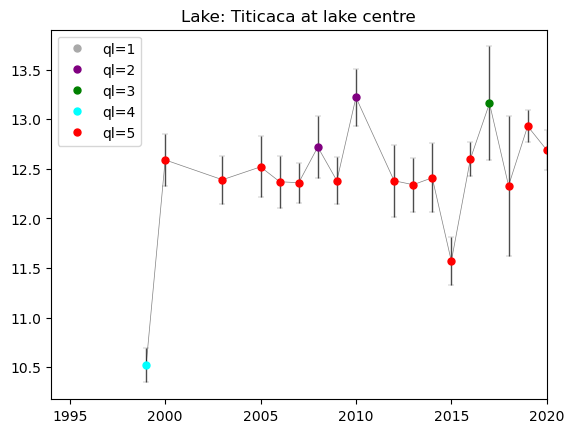

In [8]:
# Create the filename list
nc_file = np.sort(np.array(glob.glob(f'{output_dir}/*{mm+dd}*.nc')))

# Set the location on the lake where we want to extract the timeseries.
# This location is, by default, set to lake centre. The line needs to be modified to the following:
# latc, lonc = custom_lat, custom_lon to plot the values for other, custom, locations.
latc, lonc = latcentre.iloc[0], loncentre.iloc[0]

# Create empty lists to receive the data
lswt, unc, ql, y = [], [], [], []

# Loop through the separate files (one for each year) and read the LSWT, quality level and uncertainty for each 
# year
for i in range(len(nc_file)):
    y.append(int(os.path.basename(nc_file[i])[0:4]))
#    Open the file with Xarray
    xr_lake  = xr.open_dataset(nc_file[i])
#    Read LSWT of the lake centre
    T = xr_lake.lake_surface_water_temperature.sel(lat=latc, lon=lonc, method='nearest') - 273.15
#    Read LSWT uncertainty of the lake centre
    U = xr_lake.lswt_uncertainty.sel(lat=latc, lon=lonc, method='nearest')
#     Read the quality level of the lake centre.The structure is different for version 4.0 and 4.5.1
    if version == '4.0':
        Q = xr_lake.quality_level.sel(lat=latc, lon=lonc, method='nearest') 
    if version == '4.5.1':
        Q = xr_lake.lswt_quality_level.sel(lat=latc, lon=lonc, method='nearest') 
        
    lswt.append(T.values[0])
    unc.append(U.values[0])
    ql.append(Q.values[0])

# Transform the lists into numpy array
lswt  = np.array(lswt)
unc   = np.array(unc)
ql    = np.array(ql)
y     = np.array(y).astype(int)

# Plot and visualise the timeseries

# Set the colors for the quality levels
colors = ['darkgrey','purple','green','cyan','red']

# Plot the grey line connecting the available LSWT
plt.plot(y[np.logical_not(np.isnan(ql))],lswt[np.logical_not(np.isnan(ql))],'-',color='grey',lw=0.5)

# Plot the observation accoring to the quality level together with the uncertainty as an error bar.
# We loop through the quality levels (1 to 5) to assign different color in the plot for each quality level.
for i in range(1,6):
    ch = ql==i
    
    # check if any measurements with given quality level are available
    if np.any(ch):
        # plot uncertaintly level as error bar
        plt.errorbar(y[ch], lswt[ch], yerr=unc[ch], fmt='o',color=colors[i-1],alpha=0.7,ecolor='black',
                     capthick=1.9, capsize=2,ms=2,lw=1,mew=0.2,mec=colors[i-1])
    # plot LSWT values with a given color for each quality level
    plt.plot(y[ch],lswt[ch],'o',mfc=colors[i-1],color=colors[i-1],ms=5,label='ql='+str(i))
    
# Set the plot legend, title and limits for x-axis (time)        
plt.legend()
plt.xlim(1994,2020)
plt.title(f'Lake: {lake_name.title()} at lake centre')

# save the figure
png_file = f'{output_dir}/{lake_name}_timeseries.png'
plt.savefig(png_file, dpi=500)

We recommend to use **ONLY LSWT of best quality level 4 and 5**. **LSWT of quality level 1 should never be used**. If you want to use lower quality level data, careful checks have to be carried out. In the next cell, we plot only the observations of quality level 4 and 5.

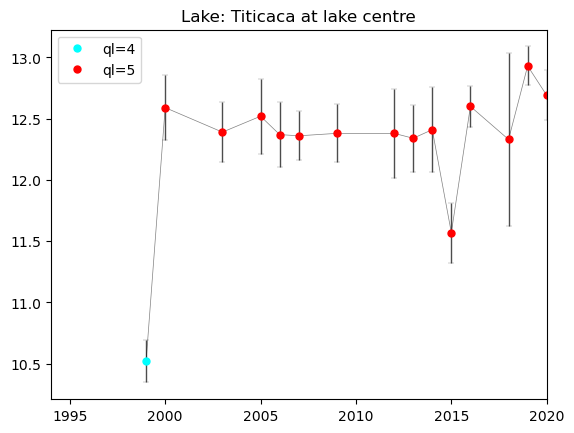

In [9]:
# Select the observation of quality level > 3
ck = np.logical_and(np.logical_not(np.isnan(ql)),ql>3)

# Plot the timeseries

# Plot the grey line connecting the available LSWT
plt.plot(y[ck],lswt[ck],'-',color='grey',lw=0.5)

# Plot the observation accoring to the quality level together with the uncertainty as an error bar
# Here we restrict the quality levels only to values 4 and 5.
for i in range(4,6):
    ch = ql==i
    
    if np.any(ch):
        plt.errorbar(y[ch], lswt[ch], yerr=unc[ch], fmt='o',color=colors[i-1],alpha=0.7,ecolor='black',
                     capthick=1.9, capsize=2,ms=2,lw=1,mew=0.2,mec=colors[i-1])
    plt.plot(y[ch],lswt[ch],'o',mfc=colors[i-1],color=colors[i-1],ms=5,label='ql='+str(i))
    
        
# Set the plot legend, title and limits for x-axis (time)
plt.legend()
plt.xlim(1994,2020)
plt.title(f'Lake: {lake_name.title()} at lake centre')

# save the figure
png_file = f'{output_dir}/{lake_name}_timeseries_ql45.png'
plt.savefig(png_file, dpi=500)

## Plotting the position on the Lake Mask 
 
For generating this figure we use the cartopy library. The lake mask showing the cells belonging to the selected lake is plotted and the position within the lake where the time series was extracted is highlighted. The lake mask extent indicates which are the pixels where the LSWT retrieval has been attempted and define the lake extent. 

This Figure is saved as lake_name_timeseries_location_YYYYMMDD.png file in the output directory.

/opt/homebrew/Caskroom/miniforge/base/envs/TM-TESTING/lib/python3.11/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/opt/homebrew/Caskroom/miniforge/base/envs/TM-TESTING/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


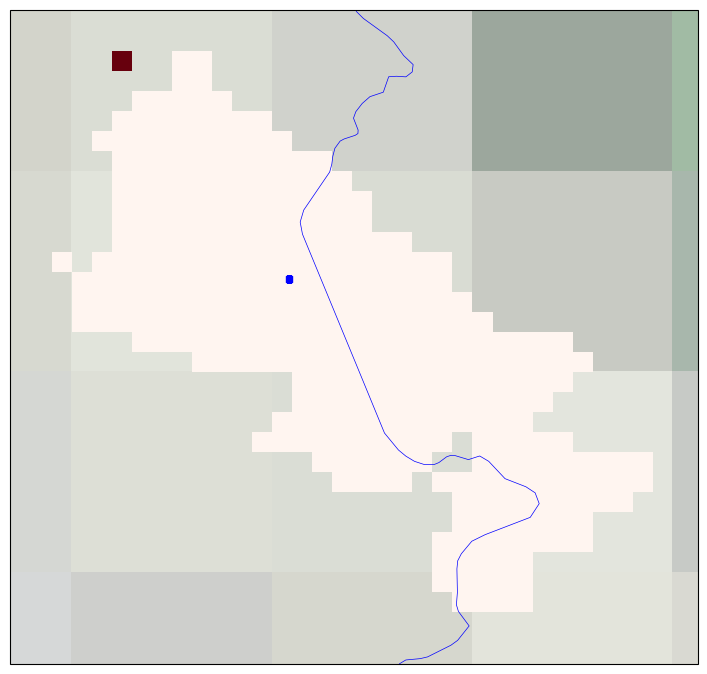

In [10]:
# Set a margin to slighlty enlarge the figure
step = 0.1

# Read the lakeid variable from the last netcdf file that has been read. Dataset structure is different for 
# version 4.0 and 4.5.1
if version == '4.0':
    lakeid = xr_lake.lakeid.sel(lat=slice(latmin-step, latmax+step), lon=slice(lonmin-step, lonmax+step))
if version == '4.5.1':
    lakeid = xr_lake.lakeid_CCI.sel(lat=slice(latmin-step, latmax+step), lon=slice(lonmin-step, lonmax+step)) 


# Plot the lake mask and the location of the centre
fig = plt.figure(figsize = (11,8.5))
ax = plt.subplot(1,1,1, projection = crs.PlateCarree())

# Formatting of the plot - adding coastlines, land borders, setting extent, title and map projection
ax.coastlines()
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor='blue')
ax.stock_img()
ax.set_extent([lonmin-step, lonmax+step, latmin-step, latmax+step])
ax.set_title(f'Lake: {lake_name.title()}')

map_proj = crs.PlateCarree()

# Plot the lake mask
lakeid.plot(cmap=plt.cm.Reds,transform=crs.PlateCarree(),subplot_kws={'projection': map_proj},add_colorbar=False)

# Plot the location of the lake centre where the LSWT time series have been extracted
plt.scatter(x = [loncentre], y = [latcentre], s = 20, marker='s', color = 'blue', transform = crs.PlateCarree())

# save the figure
png_file = f'{output_dir}/{lake_name}_timeseries_location.png'
plt.savefig(png_file, dpi=500)

## Plot the LSWT values, quality level and uncertainty 
 
 In the following, we will plot the LSWT values, associated quality level and uncertainties for the entire lake area for the selected day of the last year on record. For generating these figures we use the cartopy library. These plots show the spatial distriution of the LSWT values and the associated uncertainty and quality level accross the lake. 

 To get a better understanding of the data, both the uncertainty and quality level need to be used together. The uncertainty expresses the interval within which the result can be found while the quality level expresses the confidence in the estimate. This is often relevant in coastal areas of the lake (where the distance to land is lower than 1.5 km), where the quality level of some pixels might be low even though the uncertainties are low. On the other hand, other pixels within the lake might have high uncertainty while their quality level is 5 (best quality level). 
 
 First we plot the LSWT over the full lake for the selected day and month and for the last year in the time series and save it as lake_name_LSWT_YYYYMMDD.png file in the output directory. 

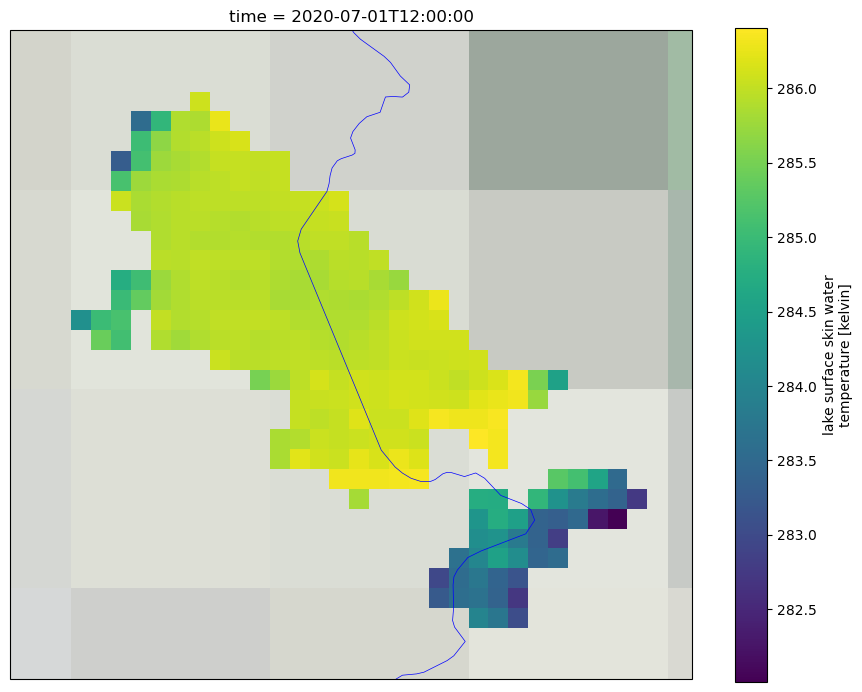

In [11]:
# Read the LSWT values for entire lake for the selected day and the last date on record
lswt_y = xr_lake.lake_surface_water_temperature.sel(lat=slice(latmin-step, latmax+step), lon=slice(lonmin-step, lonmax+step))

# Set up the plot
fig = plt.figure(figsize = (11,8.5))
ax = plt.subplot(1,1,1, projection = crs.PlateCarree())

# Formatting of the plot - adding coastlines, land borders, setting extent, title and map projection
ax.coastlines()
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor='blue')
ax.stock_img()
ax.set_extent([lonmin-step, lonmax+step, latmin-step, latmax+step])
ax.set_title(f'Lake: {lake_name.title()}')

map_proj = crs.PlateCarree()

# Plot the lake mask
lswt_y.plot(cmap=plt.cm.viridis,transform=crs.PlateCarree(),subplot_kws={'projection': map_proj})


# save the figure
png_file = f'{output_dir}/{lake_name}_LSWT_'+str(y[-1])+mm+dd+'.png'
plt.savefig(png_file, dpi=500)

Now we plot the LSWT uncertainty for the selected day and month and for the last year in the time series. This Figure is saved as lake_name_LSWT_UNC_YYYYMMDD.png file in the output directory.

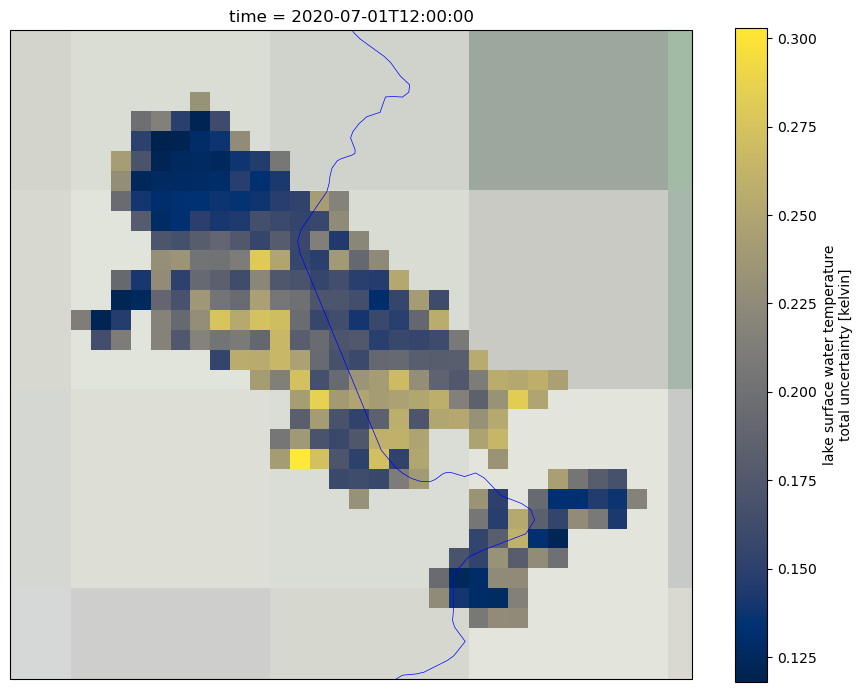

In [12]:
# Read the uncretainty values for entire lake for the selected day and the last date on record
lswt_y = xr_lake.lswt_uncertainty.sel(lat=slice(latmin-step, latmax+step), lon=slice(lonmin-step, lonmax+step))

# Set up the plot
fig = plt.figure(figsize = (11,8.5))
ax = plt.subplot(1,1,1, projection = crs.PlateCarree())

# Formatting of the plot - adding coastlines, land borders, setting extent, title and map projection
ax.coastlines()
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor='blue')
ax.stock_img()
ax.set_extent([lonmin-step, lonmax+step, latmin-step, latmax+step])
ax.set_title(f'Lake: {lake_name.title()}')

map_proj = crs.PlateCarree()

# Plot the lake mask
lswt_y.plot(cmap=plt.cm.cividis,transform=crs.PlateCarree(),subplot_kws={'projection': map_proj})


# save the figure
png_file = f'{output_dir}/{lake_name}_LSWT_UNC_'+str(y[-1])+mm+dd+'.png'
plt.savefig(png_file, dpi=500)

Lastly we plot the quality levels for the selected day and month and for the last year in the time series. This Figure is saved as lake_name_QL_YYYYMMDD.png file in the output directory.

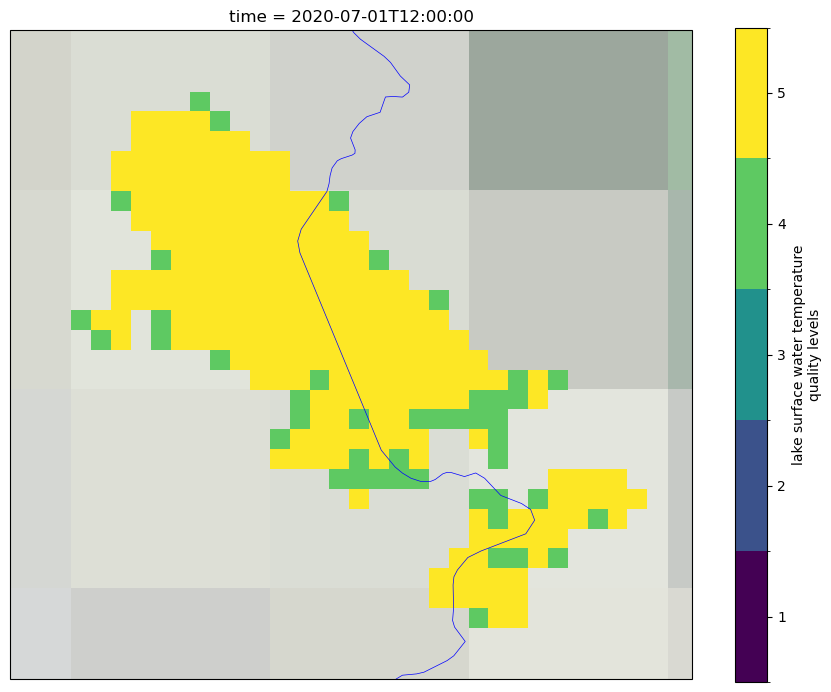

In [13]:
# Read the quality level values for entire lake for the selected day and the last date on record.
# Dataset structure is different for data version 4.0 and 4.5.1 
if version == '4.0':
    lswt_y = xr_lake.quality_level.sel(lat=slice(latmin-step, latmax+step), lon=slice(lonmin-step, lonmax+step))
if version == '4.5.1':
    lswt_y = xr_lake.lswt_quality_level.sel(lat=slice(latmin-step, latmax+step), lon=slice(lonmin-step, lonmax+step))

# Set up the plot
fig = plt.figure(figsize = (11,8.5))
ax = plt.subplot(1,1,1, projection = crs.PlateCarree())

# Formatting of the plot - adding coastlines, land borders, setting extent, title and map projection
ax.coastlines()
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor='blue')
ax.stock_img()
ax.set_extent([lonmin-step, lonmax+step, latmin-step, latmax+step])
ax.set_title(f'Lake: {lake_name.title()}')

map_proj = crs.PlateCarree()

# Plot the lake mask
lswt_y.plot(cmap=plt.cm.viridis,transform=crs.PlateCarree(),subplot_kws={'projection': map_proj},
            levels=[0.5,1.5,2.5,3.5,4.5,5.5], cbar_kwargs={'ticks': [1,2,3,4,5]})


# save the figure
png_file = f'{output_dir}/{lake_name}_QL_'+str(y[-1])+mm+dd+'.png'
plt.savefig(png_file, dpi=500)

## What have you learned?

You are now ready to download and explore the CDS Lake Surface Water Temperature dataset.

You know how to visualize the values both as a time-series for a given point within a lake, as well as a raster for a given date and selected lake.

You know how to use and interpret the associated variables - the LSWT uncertainty and the quality levels.
